In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import processes
from processes import weird as ou
import utils
from utils import kalman

/Users/apple/anaconda3/envs/DeepLearning/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/apple/anaconda3/envs/DeepLearning/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Network

In [2]:
def build_optimizer(loss, learning_rate, grad_clip):
    ''' Build optmizer for training, using gradient clipping.
    
        Arguments:
        loss: Network loss
        learning_rate: Learning rate for optimizer
    
    '''
    
    # Optimizer for training, using gradient clipping to control exploding gradients
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), grad_clip)
    train_op = tf.train.AdamOptimizer(learning_rate)
    optimizer = train_op.apply_gradients(zip(grads, tvars))
    
    return optimizer

In [3]:

graph=tf.Graph()


In [4]:
logs_dir = './graphs/'
batch_size=128
num_steps=730
lstm_layers= 1
lstm_size= 10
inputs_dim= 1
alpha = 0.1

In [5]:
with graph.as_default():
    inputs_ = tf.placeholder( tf.float32, [batch_size,num_steps, inputs_dim] , name='inputs')
    targets_ = tf.placeholder( tf.float32, [batch_size,num_steps, inputs_dim] , name='targets')
    learning_rate= tf.placeholder( tf.float32 , name='lr')
    grad_clip= tf.placeholder( tf.float32 , name='clip')

In [6]:

with graph.as_default():
    rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(lstm_size)

# 'outputs' is a tensor of shape [batch_size, max_time, cell_state_size]

# defining initial state
    initial_state = rnn_cell.zero_state(batch_size, dtype=tf.float32)

# 'state' is a tensor of shape [batch_size, cell_state_size]
    outputs, state = tf.nn.dynamic_rnn(rnn_cell, inputs_,
                                   initial_state=initial_state,
                                   dtype=tf.float32)
    W = tf.Variable(tf.random_normal([lstm_size, inputs_dim]), dtype=tf.float32) # weights
    b = tf.Variable(tf.random_normal([ inputs_dim]), dtype=tf.float32) # biases
    shape = outputs.shape
    
    outputs = tf.matmul( tf.reshape( outputs, [-1, lstm_size]), W ) + b
    outputs = tf.reshape( outputs, (shape[0],shape[1],b.shape[0]))

In [7]:
with graph.as_default():
    cost = tf.losses.mean_squared_error( outputs , targets_)
    optimizer= build_optimizer(cost, learning_rate, grad_clip)
    

## Batch

In [8]:


def batch_1( batch_size, num_steps, noise, dictionary,):
    while True:
        invariant_std = 0.2
        lbd = 1
        sigma = 0.9 #invariant_std*np.sqrt(2*lbd)
        dictionary['sigma'] = sigma
        dictionary['lbd'] = lbd

        batch = np.random.randn( batch_size,num_steps+1,1)*noise
        trend =np.reshape( ou.process(**dictionary)[: num_steps+1] , [-1,1] )
        for i in range(batch_size):
            batch[i,:,:]=batch[i,:,:]+trend[:,:]
        
        yield (batch[:,:-1,:] , batch[:,1:,:],trend )

    

In [9]:
invariant_std = 0.2
lbd = 1.
sigma = invariant_std*np.sqrt(2*lbd)

dictionary = {'deltaT': 1./365,
              'T':3}
noise= 0.1/np.sqrt( dictionary['deltaT'])
generator1 = batch_1( batch_size , num_steps,noise ,dictionary)

In [10]:
generator= generator1

## Training

## Batch 1

0.10927662849426145


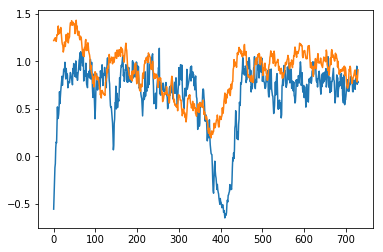

0.14123973846435423


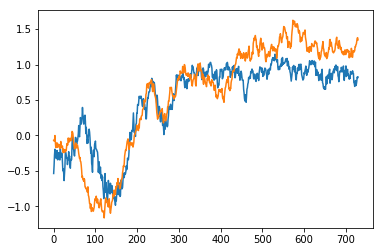

0.21473369598388548


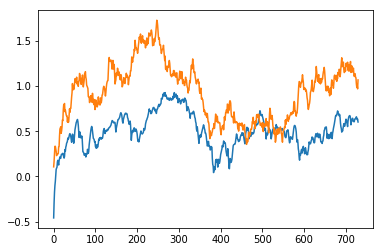

0.09236679077148313


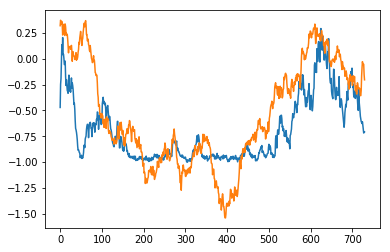

0.09177122116088743


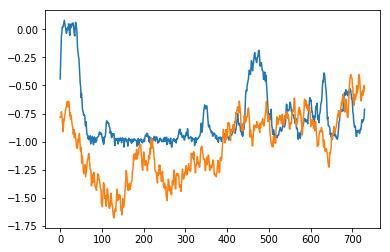

0.12864980697631712


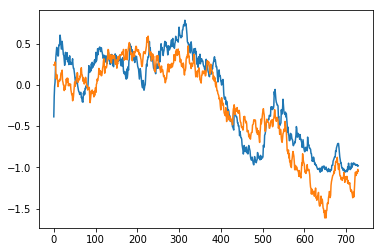

0.1609214305877673


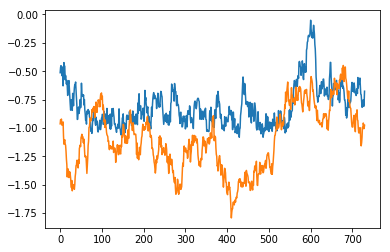

0.08868060111999387


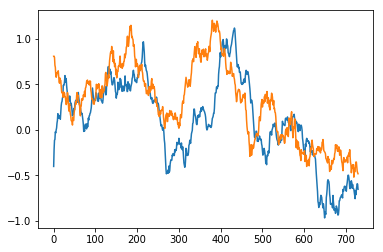

0.13446364402770872


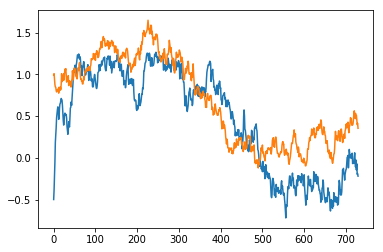

0.10305438041686887


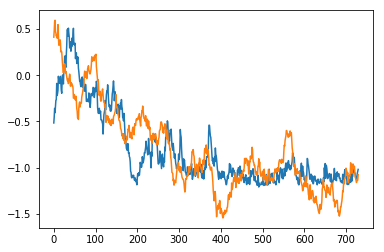

In [11]:
writer = tf.summary.FileWriter(logs_dir, graph)
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        X,Y ,trends= next(generator)
        state = sess.run( initial_state)
        variables =tf.trainable_variables()
        feed = { inputs_: X,
                initial_state :state,
               targets_: Y ,
               learning_rate: 0.01,
               grad_clip: 0.1}
        if (i+1) %100 == 0 :
            result = sess.run( [cost, outputs], feed_dict=feed)
            print( result[0]-noise**2)
            plt.plot( result[1][0,:,0])
            plt.plot( trends[1:,0])
            plt.show()
        sess.run( [optimizer], feed_dict=feed)
        

writer.close()   

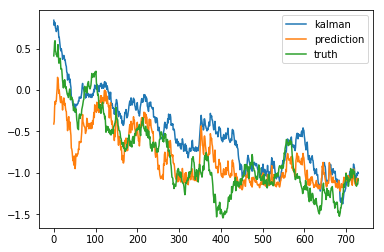

In [17]:
index=30
lbd = 1
sigma = 0.9
sigmaS= 0.1
deltaT= 1./365
kalman_result =  kalman.kalman_estimate( X[index, :,0] ,
                                 sigmaS =sigmaS ,
                                 lbd=lbd,
                                 sigmamu= sigma,
                                 deltaT=deltaT )
plt.plot(kalman_result, label='kalman' )
#plt.plot(X[index,:,0])
plt.plot( result[1][index,:,0] , label = 'prediction')
plt.plot( trends[1:,0] , label= 'truth')
plt.legend( loc='best')
plt.show()

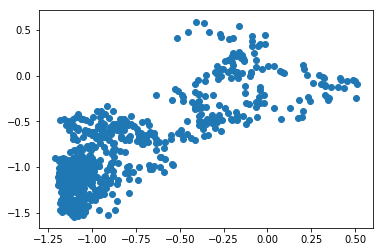

In [13]:
plt.scatter( result[1][0,:,0], trends[1:,0])
plt.show()

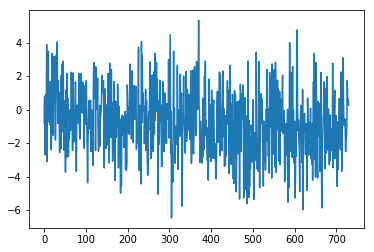

In [14]:
plt.plot(Y[0,:,0])
plt.show()

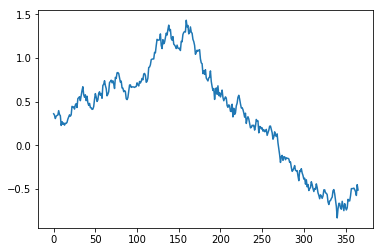

In [15]:
S = ou.process( 1,1,1./365,1)
plt.plot( S )

In [16]:
S

array([ 0.3602046 ,  0.34429728,  0.3056051 ,  0.33243504,  0.34066376,
        0.34500694,  0.39608988,  0.35189582,  0.33844866,  0.22628421,
        0.26991029,  0.23982074,  0.25485065,  0.23010478,  0.25090193,
        0.24960794,  0.26184189,  0.29868683,  0.3238409 ,  0.34795301,
        0.33235148,  0.34844694,  0.44526827,  0.43946841,  0.43935842,
        0.41395399,  0.46203613,  0.4759346 ,  0.43223396,  0.53376259,
        0.54571056,  0.55578126,  0.51050395,  0.56639498,  0.62683102,
        0.67017293,  0.57849439,  0.54958806,  0.57787323,  0.51068766,
        0.56136646,  0.48726679,  0.45669026,  0.47904857,  0.43101542,
        0.42970504,  0.41106766,  0.41291948,  0.442869  ,  0.52661622,
        0.59109346,  0.5526829 ,  0.50151572,  0.51978876,  0.59315093,
        0.61243463,  0.57196019,  0.59267435,  0.53784433,  0.68530479,
        0.69810907,  0.73902848,  0.68410901,  0.64980309,  0.56643154,
        0.58395277,  0.61336254,  0.71934845,  0.72926006,  0.74